# Plot gene expression in home-cage data

Here we use pre-computed UMAP coordinates. PCA and UMAP were fit using a subselect of OSNs (balanced with equal numbers of cells per OR; see `olfr.subset_source_OR_indices()`), and then transformed to all OSNs. UMAP was fit on the top 20 PCs from the top 1350 HVGs (whose names can be found in the NMF loadings file). Likewise, NMF gene expression programs (GEPs) were identified using the consensus NMF method of Kotliar et al. 2019, again balance for OR frequency. The resulting gene loadings (see [Table S2](../data/tables/GSE173947_Table_S2_nmf_loadings.csv)) were then held constant and NMF was refit to get usages for all cells.

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cmocean

from osn.olfr import olfr
from osn.preprocess.util import get_data_folders
from osn.viz import viz

In [3]:
sns.set_context("notebook")
sns.set(font_scale=1.5, style="ticks", palette="tab10")

# load home-cage adata and subselect ORs expressed in enough cells

In [4]:
data_fold = get_data_folders()
ad_fn = data_fold.processed / "home_cage_norm.h5ad"
adata = sc.read(ad_fn)
print(adata)

AnnData object with n_obs × n_vars = 38345 × 30681
    obs: 'top_Olfr', 'source', 'orig_ident', 'ES_score', 'UMAP_1', 'UMAP_2', 'round2', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_high_expr', 'log1p_total_counts_high_expr', 'pct_counts_high_expr', 'good_total_counts', 'OR_counts', 'OR_counts_norm'
    var: 'mito', 'ribo', 'high_expr', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_nmf', 'X_umap'


In [5]:
# find which cells express Olfrs in enough cells
SOURCE_THRESH = 10
df_OR, has_OR = olfr.get_OR_info(adata)
good_ORs, has_enough_ORs = olfr.filter_OR_source(df_OR, SOURCE_THRESH)
n_OR = len(good_ORs)
df_OR_keep = df_OR[has_enough_ORs]
print(f"Found {n_OR} ORs with at least {SOURCE_THRESH} cells per OR; keeping {len(df_OR_keep)} OSNs")

# take mean across OSNs expressing each OR
df_mean = df_OR_keep.groupby('top_Olfr').mean()

Found 831 ORs with at least 10 cells per OR; keeping 37441 OSNs


In [6]:
gep_name_mapping = {}
for g in adata.obsm["X_nmf"]:
    if "GEP" in g:
        gep_name_mapping[g] = g
    else:
        gep_name_mapping[g] = f"GEP$_{{{g}}}$"

# Plot GEP usage at OSN and OR level 

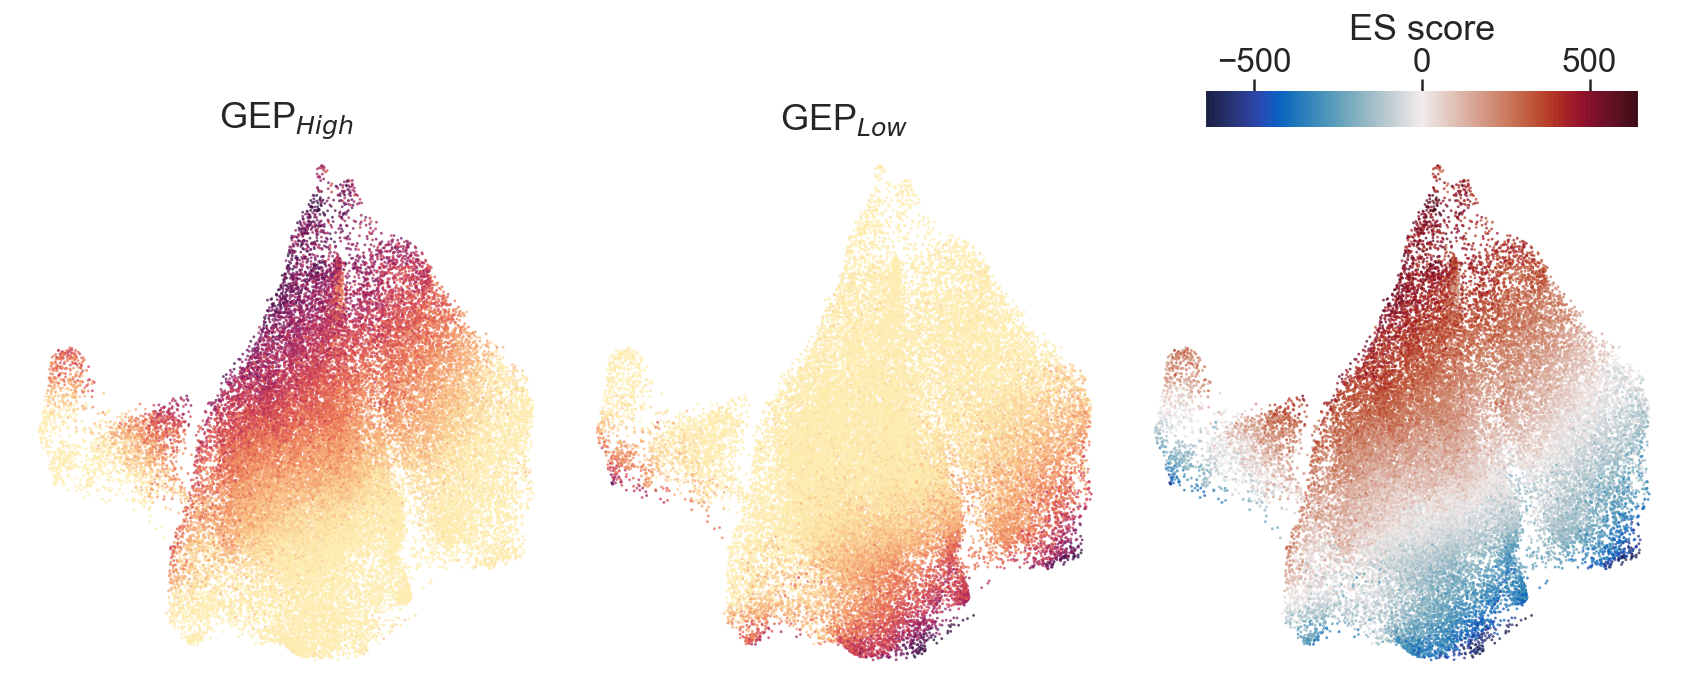

In [7]:
xu, yu = adata.obsm['X_umap'][has_OR].T

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
cols = ['High', 'Low']
for ax, col in zip(axes[:2], cols):
    g = df_OR[col]
    cmax = np.percentile(g, 99.95)
    ax.scatter(
        xu, yu, c=g, vmax=cmax, s=2, alpha=0.75, lw=0, rasterized=True, cmap="cmo.matter",
    )
    ax.set_title(gep_name_mapping[col])
    
ax = axes[-1]
ess = df_OR.ES_score
cmax = np.percentile(np.abs(ess), 99.95)
scatter = ax.scatter(
    xu, yu, c=ess, vmax=cmax, vmin=-1*cmax, s=2, alpha=0.75, lw=0, rasterized=True, cmap="cmo.balance",
)

for ax in axes:
    ax.axis("off")
    ax.set_box_aspect(1)
    
cbar, _ = viz.plt_cbar(fig, scatter, pos=[0.68, 0.9, 0.2, 0.05], lab="ES score")
viz.update_cbar(cbar)

plt.subplots_adjust(wspace=0)

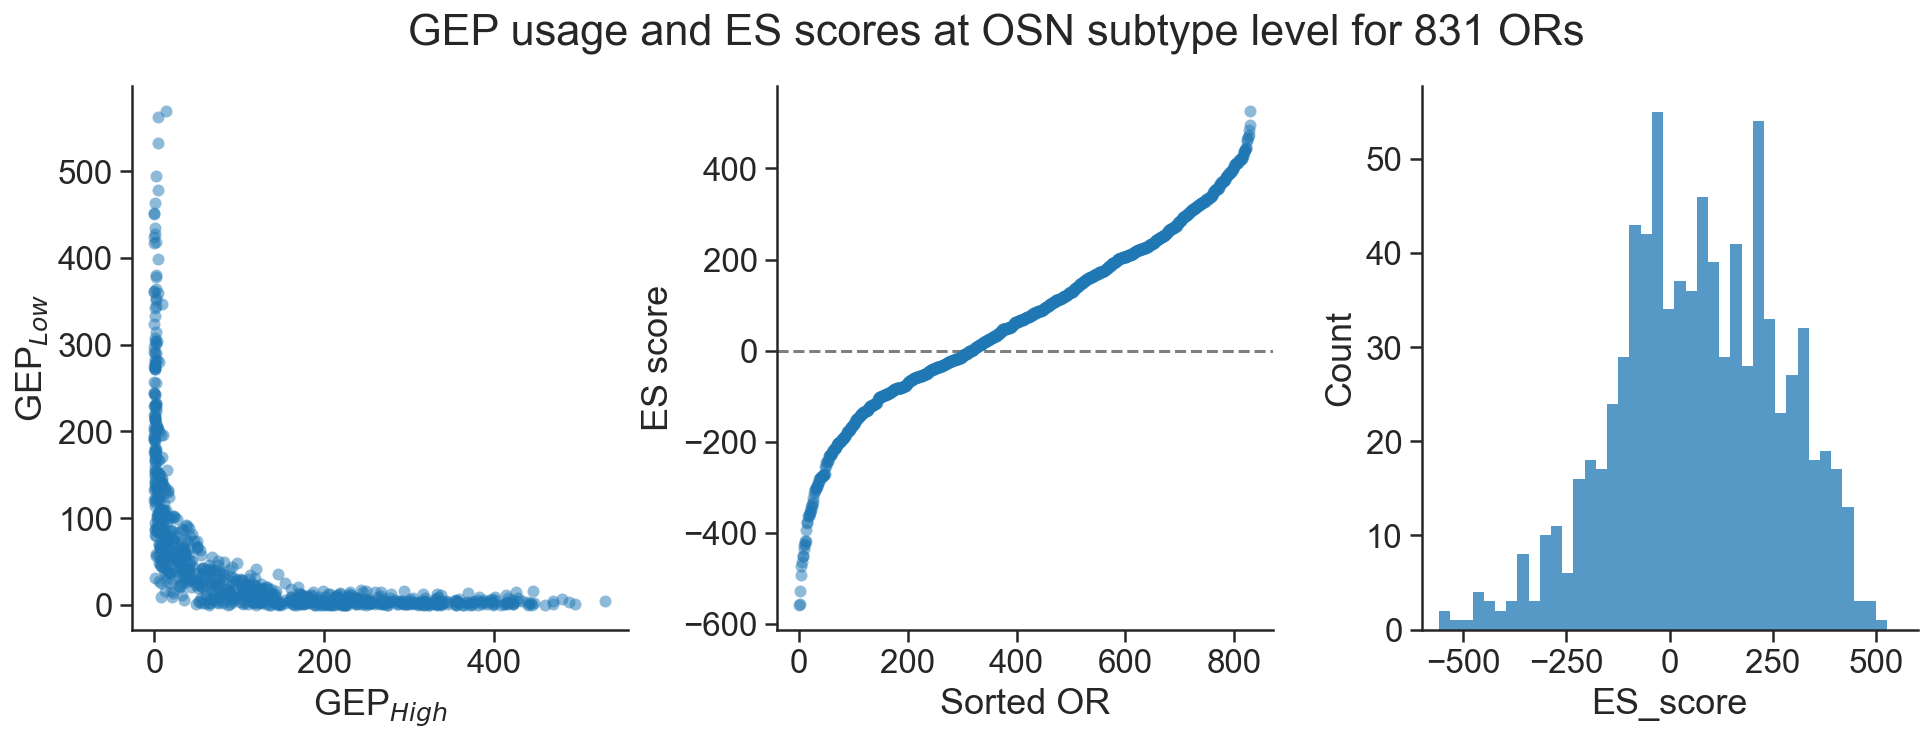

In [8]:
# each dot is an OR
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
ax.scatter(df_mean.High, df_mean.Low, alpha=0.5, lw=0)
ax.set_xlabel(gep_name_mapping["High"])
ax.set_ylabel(gep_name_mapping["Low"])

ax2.scatter(np.arange(len(good_ORs)), np.sort(df_mean.ES_score), alpha=0.5, lw=0)
ax2.axhline(0, ls="--", zorder=-10, color="k", alpha=0.5)
ax2.set_xlabel("Sorted OR")
ax2.set_ylabel("ES score")

sns.histplot(df_mean.ES_score, ax=ax3, bins=40, lw=0)
ax3.set_xlim(-600, 600)

sns.despine()
fig.suptitle(f"GEP usage and ES scores at OSN subtype level for {n_OR} ORs")
plt.subplots_adjust(wspace=0.3)

# Example genes at OSN and OR level 

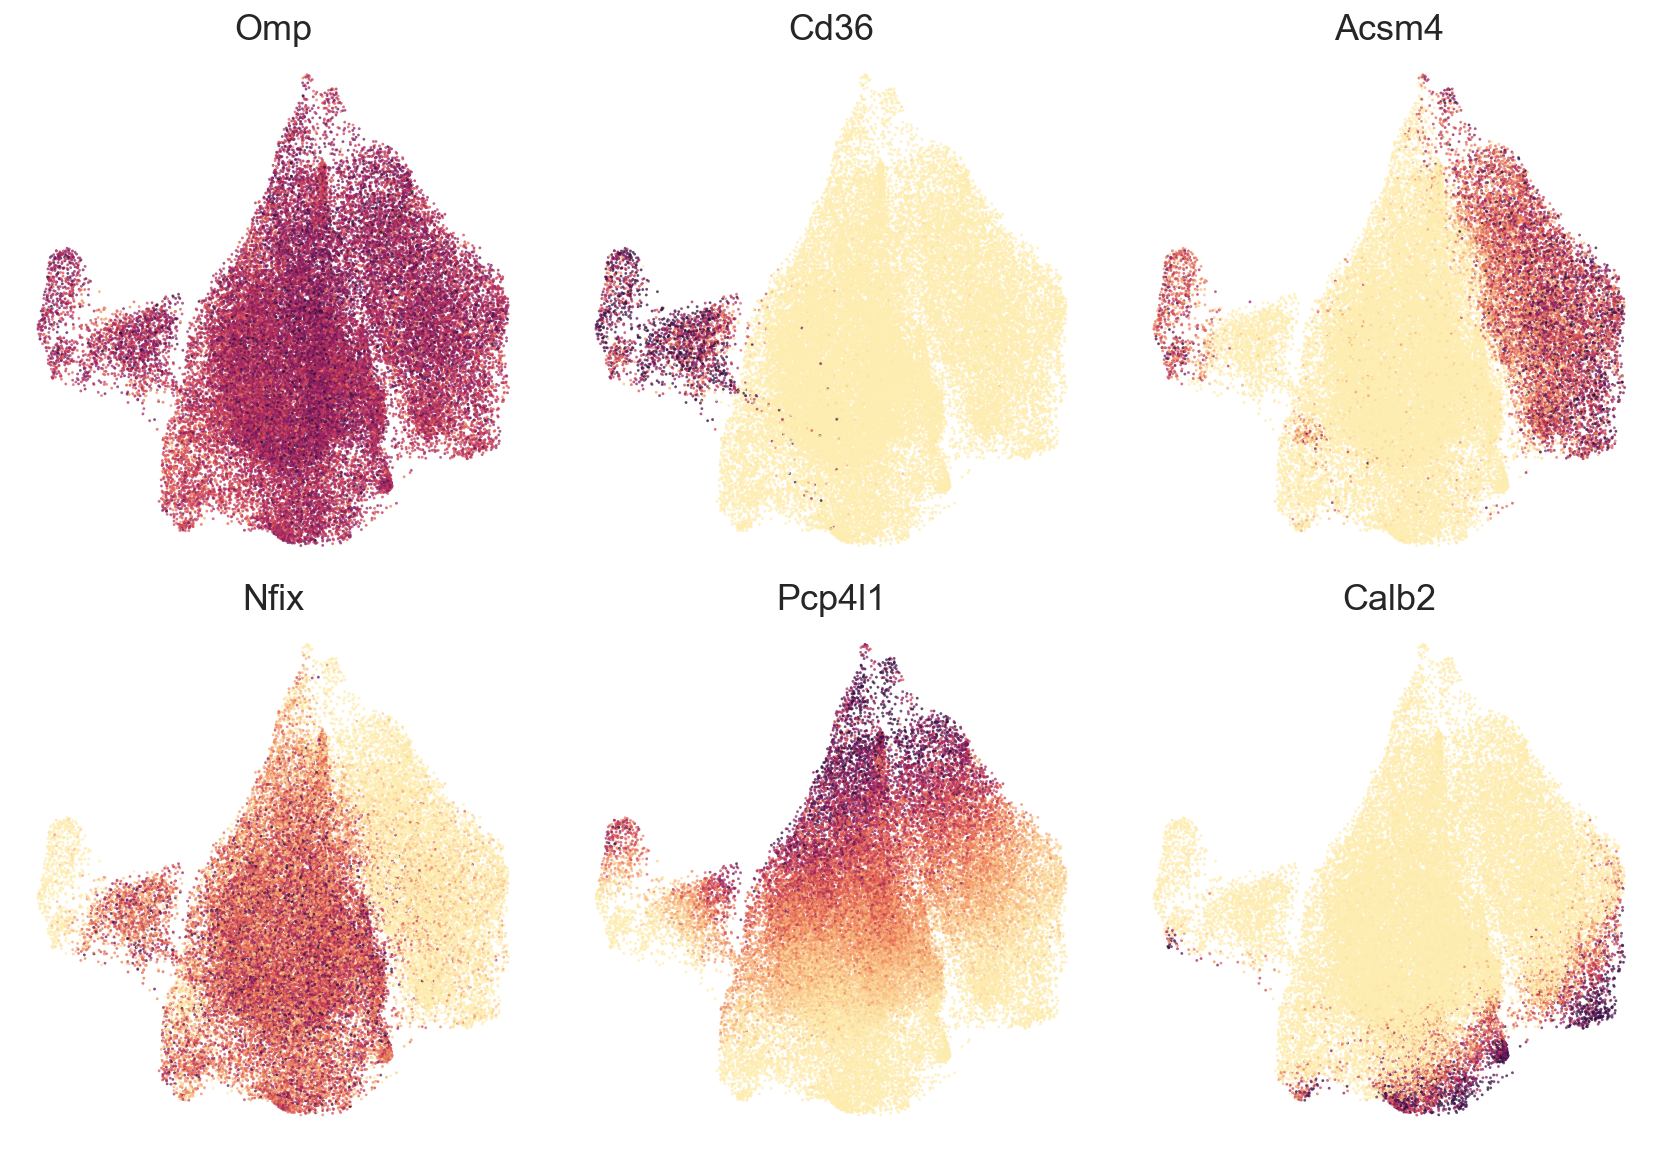

In [9]:
marker_genes = ["Omp", "Cd36", "Acsm4", "Nfix", "Pcp4l1", "Calb2"]
df_markers = sc.get.obs_df(adata, marker_genes).loc[df_OR.index]

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
for ax, gn in zip(axes.flatten(), marker_genes):
    g = df_markers[gn]
    cmax = np.percentile(g, 99)
    ax.scatter(
        xu, yu, c=g, vmax=cmax, s=2, alpha=0.75, lw=0, rasterized=True, cmap="cmo.matter",
    )
    ax.set_title(gn)
    ax.axis("off")
    ax.set_box_aspect(1)
    
plt.subplots_adjust(wspace=0, hspace=0.1)

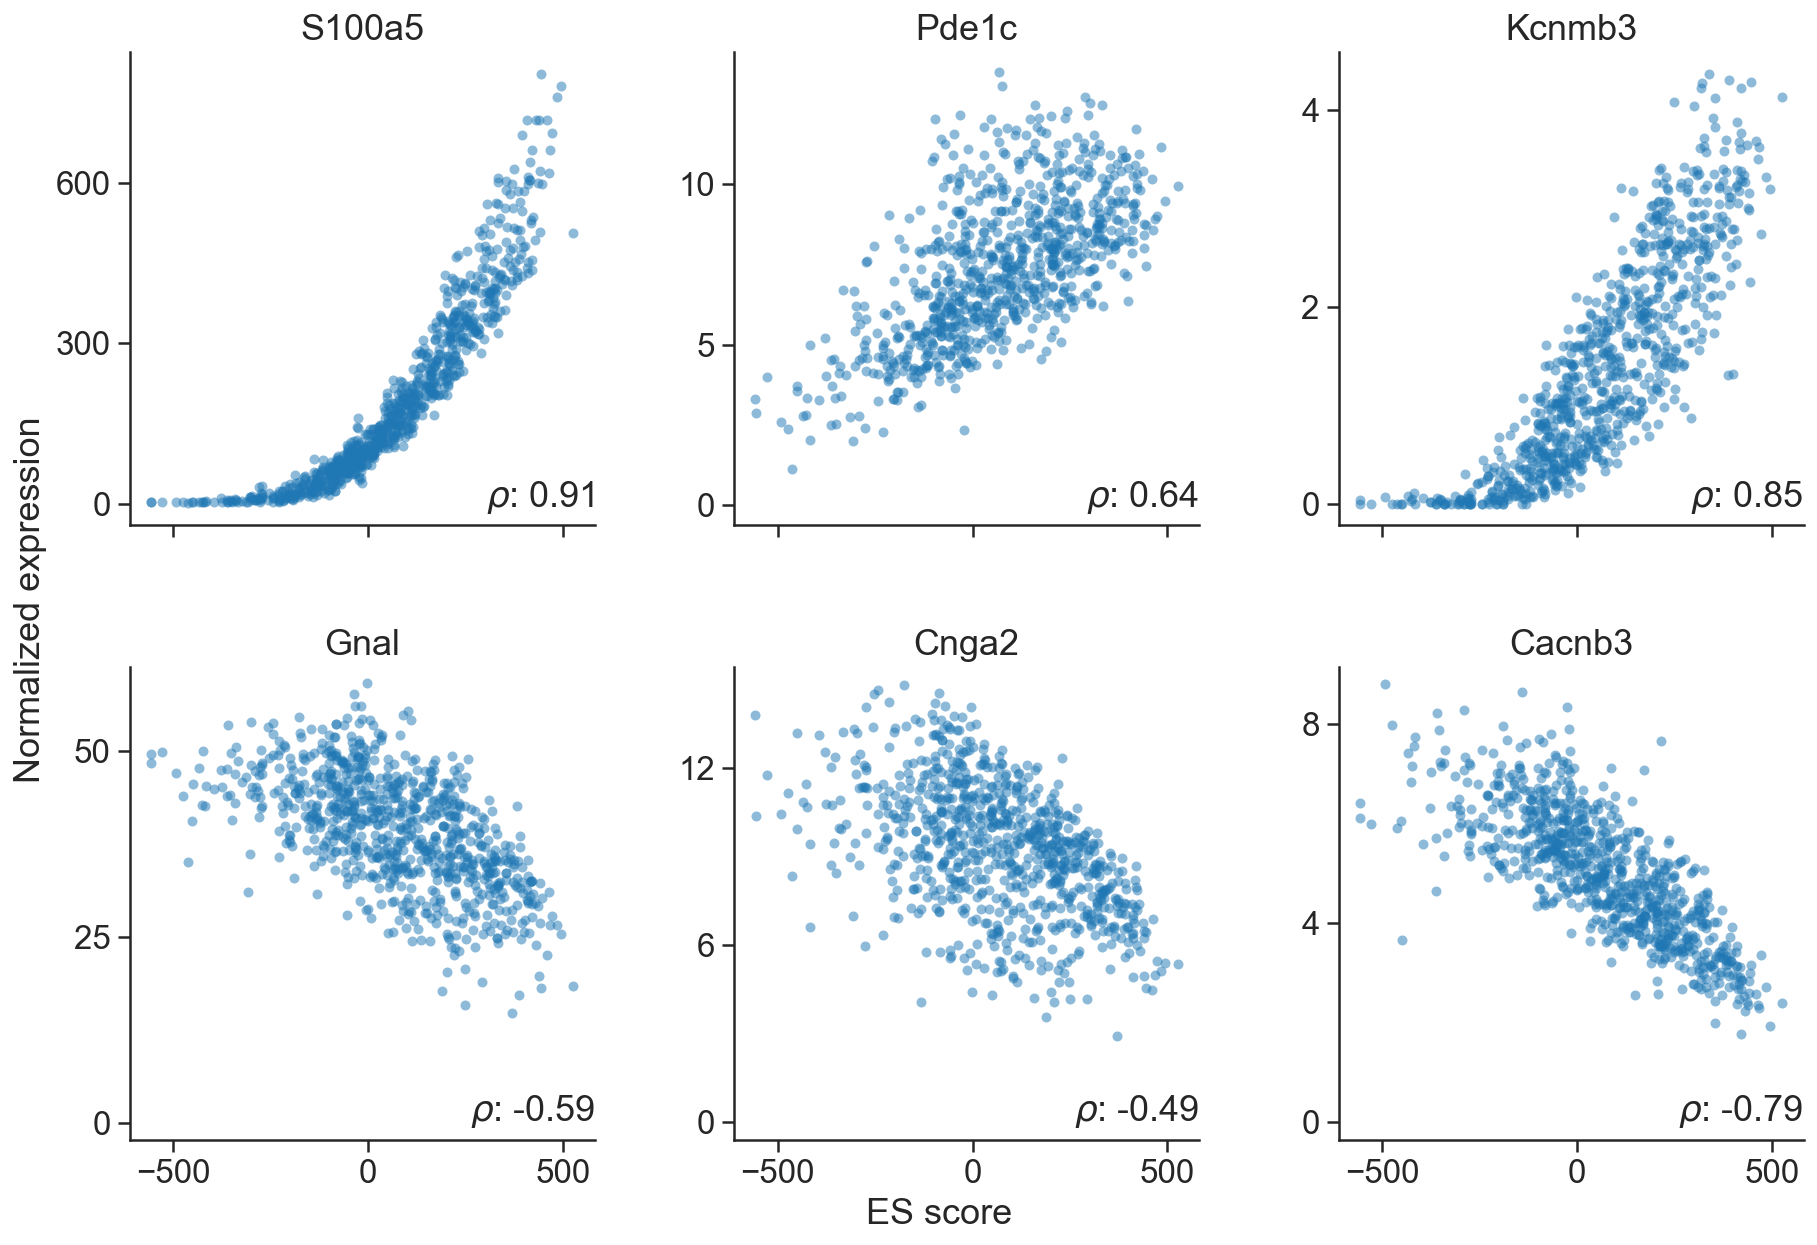

In [10]:
genes6 = ["S100a5", "Pde1c", "Kcnmb3", "Gnal", "Cnga2", "Cacnb3"]
df_genes = sc.get.obs_df(adata, genes6)
df_hvg_mean = df_OR_keep.join(df_genes).groupby("top_Olfr").mean()

fig, axes = viz.plot_genes(genes6, df_hvg_mean, vert=False, plot_corr=True)